In [90]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import math
from collections import Counter

def calculate_entropy(data):
    # Count the frequency of each value in the dataset
    data_count = Counter(data)
    
    # Calculate the total number of samples
    total_samples = len(data)
    
    # Calculate the entropy
    entropy = 0.0
    for count in data_count.values():
        probability = count / total_samples
        entropy -= probability * math.log2(probability)
    
    return entropy

In [91]:
group = 4

[-1570 -2018 -2338 -1634 -1890 -1313 -1570 -1441 -2274 -1698 -1570 -1441
 -1377 -1313 -1698 -1762 -1185 -1249 -1441 -1570]
min/max and entropy 9704 -8488 6.8860383016859545
unique 266
Number of channels: 1
Sample width: 2
Frame rate: 19531
Number of frames: 98689
Size in bytes: 197378


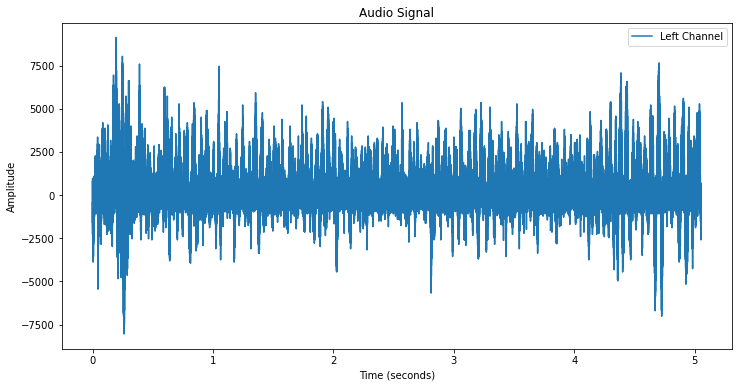

In [92]:
# Function to read wav file in raw mode
def read_wav_raw(file_path):
    # Open the wav file
    with wave.open(file_path, 'rb') as wav_file:
        # Extract basic information
        num_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        frame_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        
        # Read raw audio data
        raw_audio_data = wav_file.readframes(num_frames)
        
        audio_data = np.frombuffer(raw_audio_data, dtype=np.int16)
        print(audio_data[:20])
        
        shifted_audio_data = np.zeros(num_frames, dtype=np.int16)
        for i in range(num_frames // group):
            #print(i*group, (i+1)*group)
            shifted_audio_data[(i*group):((i+1)*group)] = audio_data[(i*group):((i+1)*group)] - audio_data[i*group]
            shifted_audio_data[i*group] = audio_data[i*group]

        print("min/max and entropy", np.max(audio_data), np.min(audio_data), calculate_entropy(audio_data))
        print("unique", len(np.unique(audio_data)))
        
        # Print the extracted information
        print(f"Number of channels: {num_channels}")
        print(f"Sample width: {sample_width}")
        print(f"Frame rate: {frame_rate}")
        print(f"Number of frames: {num_frames}")
        print(f"Size in bytes: {num_frames*2}")

        time_axis = np.linspace(0, num_frames / frame_rate, num=num_frames)
        
        # Plot the audio data
        plt.figure(figsize=(12, 6))
        plt.plot(time_axis, shifted_audio_data, label='Left Channel')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title('Audio Signal')
        plt.legend()
        plt.show()
        
        return shifted_audio_data

# Usage example
file_path = 'data/0052503c-2849-4f41-ab51-db382103690c.wav'  # Replace with the path to your .wav file
raw_data = read_wav_raw(file_path)

In [76]:
print(raw_data[0:32])

[-1570  -448  -768   -64 -1890   577   320   449 -2274   576   704   833
 -1377    64  -321  -385 -1185   -64  -256  -385 -1698   577   961     0
 -1570  -128  -384   -64 -1890  -320  -128  -448]


In [101]:
import heapq
from collections import defaultdict, Counter
import numpy as np

class Node:
    def __init__(self, value=None, freq=None, left=None, right=None):
        self.value = value
        self.freq = freq
        self.left = left
        self.right = right

    # Define comparison operators for priority queue
    def __lt__(self, other):
        return self.freq < other.freq

def build_frequency_table(data):
    frequency = Counter(data)
    return frequency

def build_huffman_tree(frequency):
    priority_queue = [Node(value, freq) for value, freq in frequency.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)
        merged = Node(freq=left.freq + right.freq, left=left, right=right)
        heapq.heappush(priority_queue, merged)

    return priority_queue[0]

def generate_huffman_codes(node, prefix='', codebook=None):
    if codebook is None:
        codebook = {}

    if node.value is not None:
        codebook[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + '0', codebook)
        generate_huffman_codes(node.right, prefix + '1', codebook)

    return codebook

def huffman_encode(data, codebook):
    return ''.join(codebook[value] for value in data)

def huffman_encoding(data):
    frequency_table = build_frequency_table(data)
    huffman_tree = build_huffman_tree(frequency_table)
    codebook = generate_huffman_codes(huffman_tree)
    print(codebook)
    encoded_data = huffman_encode(data, codebook)
    return encoded_data, huffman_tree

def huffman_decode(encoded_data, huffman_tree):
    decoded_data = []
    node = huffman_tree
    for bit in encoded_data:
        if bit == '0':
            node = node.left
        else:
            node = node.right

        if node.value is not None:
            decoded_data.append(node.value)
            node = huffman_tree

    return decoded_data

In [100]:
# Example usage
data = raw_data
extracted_arrays = np.concatenate([data[(i*group+1):(i*group+group)] for i in range(len(data) // group)])

encoded_data, huffman_tree = huffman_encoding(extracted_arrays)
decoded_data = huffman_decode(encoded_data, huffman_tree)
print(decoded_data)

encoded_data2, huffman_tree2 = huffman_encoding(data[0::group])
decoded_data2 = huffman_decode(encoded_data2, huffman_tree2)

print(f"Decoding matches original: {np.array_equal(extracted_arrays, decoded_data)}")
print(f"Decoding matches original: {np.array_equal(data[0::group], decoded_data2)}")

{-383: '00000000', 1280: '00000001000000', -1665: '00000001000001', 1218: '0000000100001', 1281: '000000010001', 895: '00000001001', 1089: '0000000101', 703: '000000011', 511: '00000010', -511: '00000011', 513: '000001', -512: '000010', -705: '0000110', 447: '00001110', 1025: '000011110', -703: '000011111', 192: '0001', 193: '001000', -193: '001001', 640: '0010100', -1025: '001010100', -1216: '001010101000', 1154: '00101010100100', -1473: '00101010100101', 1408: '0010101010011', -1152: '001010101010', -1346: '00101010101100', -1218: '0010101010110100', -1536: '0010101010110101', -1666: '0010101010110110', -1793: '0010101010110111', 1344: '0010101010111', -767: '0010101011', -447: '00101011', 641: '0010110', -640: '0010111', -449: '001100', -768: '00110100', 768: '00110101', -833: '00110110', 961: '001101110', 896: '001101111', 449: '001110', -641: '0011110', 833: '00111110', -1921: '0011111100000000', -2241: '0011111100000001', -1729: '0011111100000010', -2818: '0011111100000011', 1793

In [96]:
a = len(encoded_data) / 8 + len(encoded_data2) / 8
print(len(encoded_data) / 8)
print(len(encoded_data2) / 8)

print(a)

51242.25
21318.0
72560.25


In [71]:
raw_data.size*2 / a

2.7201945969039523

In [51]:
import numpy as np
import heapq
from collections import Counter

class Node:
    def __init__(self, value=None, freq=None, left=None, right=None):
        self.value = value
        self.freq = freq
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

def build_frequency_table(data):
    frequency = Counter(data)
    return frequency

def build_huffman_tree(frequency):
    priority_queue = [Node(value, freq) for value, freq in frequency.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)
        merged = Node(freq=left.freq + right.freq, left=left, right=right)
        heapq.heappush(priority_queue, merged)

    return priority_queue[0]

def generate_huffman_codes(node, prefix='', codebook=None):
    if codebook is None:
        codebook = {}

    if node.value is not None:
        codebook[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + '0', codebook)
        generate_huffman_codes(node.right, prefix + '1', codebook)

    return codebook

def huffman_encode(data, codebook):
    return ''.join(codebook[value] for value in data)

def huffman_decode(encoded_data, huffman_tree):
    decoded_data = []
    node = huffman_tree
    current_bits = ""

    for bit in encoded_data:
        current_bits += bit
        current_node = node
        for bit in current_bits:
            if bit == '0':
                current_node = current_node.left
            else:
                current_node = current_node.right
        
        if current_node.value is not None:
            decoded_data.append(current_node.value)
            current_bits = ""

    return decoded_data

def dft_compression(data):
    # Step 1: Compute the DFT
    transformed_data = np.fft.fft(data)

    # Step 2: Separate real and imaginary parts and convert to 16-bit integers
    real_parts = (np.round(transformed_data.real).astype(np.single).view(np.uint32) >> 16).astype(np.uint16)
    imag_parts = (np.round(transformed_data.imag).astype(np.single).view(np.uint32) >> 16).astype(np.uint16)

    # Combine real and imaginary parts for Huffman encoding
    combined_data = np.vstack((real_parts, imag_parts)).flatten()

    # Step 3: Build Huffman codes for the combined data
    frequency_table = build_frequency_table(combined_data)
    huffman_tree = build_huffman_tree(frequency_table)
    codebook = generate_huffman_codes(huffman_tree)

    # Step 4: Encode the data using Huffman codes
    encoded_data = huffman_encode(combined_data, codebook)
    return encoded_data, huffman_tree, transformed_data.shape

def dft_decompression(encoded_data, huffman_tree, shape):
    # Step 5: Decode the data using Huffman codes
    combined_data = huffman_decode(encoded_data, huffman_tree)

    # Step 6: Separate real and imaginary parts and reshape
    combined_data = np.array(combined_data, dtype=np.uint16)
    combined_data = (combined_data.astype(np.uint32) << 16).view(np.single)
    
    half_length = combined_data.size // 2
    real_parts = combined_data[:half_length].reshape(shape)
    imag_parts = combined_data[half_length:].reshape(shape)

    # Reconstruct the complex DFT coefficients
    transformed_data = real_parts + 1j * imag_parts

    # Step 7: Compute the inverse DFT
    decompressed_data = np.fft.ifft(transformed_data).real
    return decompressed_data

# Example usage
data = raw_data
encoded_data, huffman_tree, shape = dft_compression(data)
decompressed_data = dft_decompression(encoded_data, huffman_tree, shape)

print(f"Original data: {data}")
print(f"Original data size: {data.size*2}")

print(f"Encoded data length: {len(encoded_data)/8}")
print(f"Decompressed data: {np.round(decompressed_data)}")
print(f"Decoding matches original: {np.allclose(data, np.round(decompressed_data), atol=1e-5)}")


Original data: [-1570  -448  -768 ...    64  -128     0]
Original data size: 197378
Encoded data length: 265752.5
Decompressed data: [-1.565e+03 -4.440e+02 -7.650e+02 ...  6.600e+01 -1.270e+02 -1.000e+00]
Decoding matches original: False


In [52]:
 len(encoded_data)/8

265752.5

In [53]:
import math
import numpy as np

def golomb_rice_encode(data, M):
    encoded_data = ""
    b = int(math.log2(M))
    
    for number in data:
        q = number // M
        r = number % M
        
        # Encode quotient using unary code
        encoded_data += '0' * q + '1'
        
        # Encode remainder using binary representation
        r_bin = format(r, f'0{b}b')
        encoded_data += r_bin
        
    return encoded_data

def golomb_rice_decode(encoded_data, M):
    decoded_data = []
    b = int(math.log2(M))
    i = 0
    while i < len(encoded_data):
        # Decode quotient
        q = 0
        while encoded_data[i] == '0':
            q += 1
            i += 1
        i += 1  # Skip the '1' after the zeros
        
        # Decode remainder
        r_bin = encoded_data[i:i + b]
        r = int(r_bin, 2)
        i += b
        
        # Compute the original number
        number = q * M + r
        decoded_data.append(number)
        
    return decoded_data

# Example usage
data = raw_data
M = 8192  # Choose a parameter M (power of 2)

encoded_data = golomb_rice_encode(data, M)
decoded_data = golomb_rice_decode(encoded_data, M)

# print(f"Original data: {data}")
# print(f"Encoded data: {encoded_data}")
print(f"Encoded data size: {len(encoded_data)/8}")

# print(f"Decoded data: {decoded_data}")
print(f"Decoding matches original: {np.array_equal(data, decoded_data)}")


Encoded data size: 172707.625
Decoding matches original: False
